In [1]:
## Implementing JPEG

In [2]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import math 
from matplotlib.colors import Normalize
import matplotlib.cm as cm
np.set_printoptions(precision=2,suppress=True)
from sklearn.metrics import mean_squared_error


In [3]:
### Find the size of the input imgae
print(f"The size of the input image is {os.path.getsize('cameraman.tif')} bytes")

The size of the input image is 65240 bytes


In [4]:
def DCTcoefficient(gray_img,B=8):
    h,w = gray_img.shape
    blocksV=h//B
    blocksH=w//B
    vis0 = np.zeros((h,w), np.float32)
    Trans = np.zeros((h,w), np.float32)
    vis0[:h, :w] = gray_img
    for row in range(blocksV):
            for col in range(blocksH):
                    currentblock = cv2.dct(vis0[row*B:(row+1)*B,col*B:(col+1)*B])
                    Trans[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
    cv2.imwrite('Transformed.jpg', Trans)
    return Trans
# cv2.cv.SaveImage('Transformed.jpg', cv2.cv.fromarray(Trans))

In [7]:
# Lossless source coding
# A matrix has all the quantized dct coefficients
import numpy as np
def encode_single(x):
    x = np.int16(x)
    if(x == 0):
        return '0'
    l = int(np.log2(np.abs(x)))
    if(x < 0):
        b = np.binary_repr((abs(x) ^ 2**(l+1)-1),width = l+1)
    else:
        b = np.binary_repr(x)
    return (l+1)*'1' + '0' + b



In [8]:

def bitstream(A,B=8):
    h,w = A.shape
    blocksV=h//B
    blocksH=w//B
    output_stream = ""
    for row in range(blocksV):
            for col in range(blocksH):
                z = A[row*B:(row+1)*B,col*B:(col+1)*B].flatten()
                for i in range(len(z)):
                    output_stream = output_stream+encode_single(z[i])
    with open('bitstream.txt', 'w') as f:
        f.write(output_stream)
    return output_stream
      

In [9]:
def decode(os):
    m = len(os)
    count = 0
    onecount = 0
    x= 0
    D=[]
    while x< m:
        a = int(os[x])
        if a ==1:
            onecount+=1
        elif a==0 and onecount ==0:
            D.append(0)
            count = count+1
        elif a==0 and onecount>0:
            l = 2**onecount
            s = os[x+1:x+onecount+1]
            b = int(s, base=2)
            if b<l//2:
                D.append(b-l+1)
            else:
                D.append(b)
            x+=onecount
            onecount = 0
        x+=1

    return D




In [11]:
def iDCTCoefficient(A,B=8):
    h,w = A.shape
    blocksV=h//B
    blocksH=w//B
    vis0 = np.zeros((h,w), np.float32)
    Trans = np.zeros((h,w), np.float32)
    vis0[:h, :w] = A
    for row in range(blocksV):
            for col in range(blocksH):
                    currentblock = cv2.idct(vis0[row*B:(row+1)*B,col*B:(col+1)*B])
                    Trans[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
    return Trans


In [12]:
def rearrange(decoded):
    decode = np.array(decoded)
    De = np.reshape(decode, (256, 256))
    B = 8
    h,w = 256,256
    blocksV=h//B
    blocksH=w//B
    i = 0
    De = np.zeros((256,256))
    for row in range(blocksV):
            for col in range(blocksH):
                De[row*B:(row+1)*B,col*B:(col+1)*B] = decode[i:i+64].reshape(8,8)
                i+=64    
    return De
    

In [21]:
def calmse(prn=False):
    B=8 #blocksize
    gray_img = cv2.imread('cameraman.tif',0)
    dctI = DCTcoefficient(gray_img,B=8)
    outstream = bitstream(dctI ,B=8)
    decodes= decode(outstream)
    decodeI = rearrange(decodes)
    IdctI = iDCTCoefficient(decodeI) 
    if prn ==True:
        cv2.imwrite('Reconstructed_img_b.jpg', IdctI)
        plt.imshow(IdctI)
        
        print(f"Length of coded stream {len(outstream)} bits")
        print(f"shape of decoded matrix {len(decodes)}")
        
        print(f"shape of rdctI matrix{IdctI.shape}")
    
    mse = mean_squared_error(gray_img.flatten(),IdctI.flatten())
    print(f"The mse between gray image and reconstructed image is {mse}")
    return mse, len(outstream)
     

length of coded stream 353276 bits
shape of decoded matrix 65536
shape of rdctI matrix(256, 256)
MSE:0.3025842010974884
The mse between gray image and reconstructed image is 0.3025842010974884


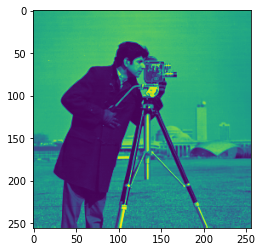

In [20]:
### Calculate the value of mse for a,b,c = 10,40,20
mse, outlen1 = calmse(prn=True)
